In [1]:
import os
import torch
import transformers
import torchist

import neuzips

os.environ["TOKENIZERS_PARALLELISM"] = "false"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

manager = neuzips.Manager(precision=7, normalizer_size=0)



/mnt/nvme/yongchang/miniforge3/envs/cuda121/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
matrices = []
for size in [8, 32, 128, 512, 2048, 4096, 8192, 16384, 32768]:
    matrices.append(torch.randn(size, size, dtype=torch.bfloat16, device="cuda:0"))

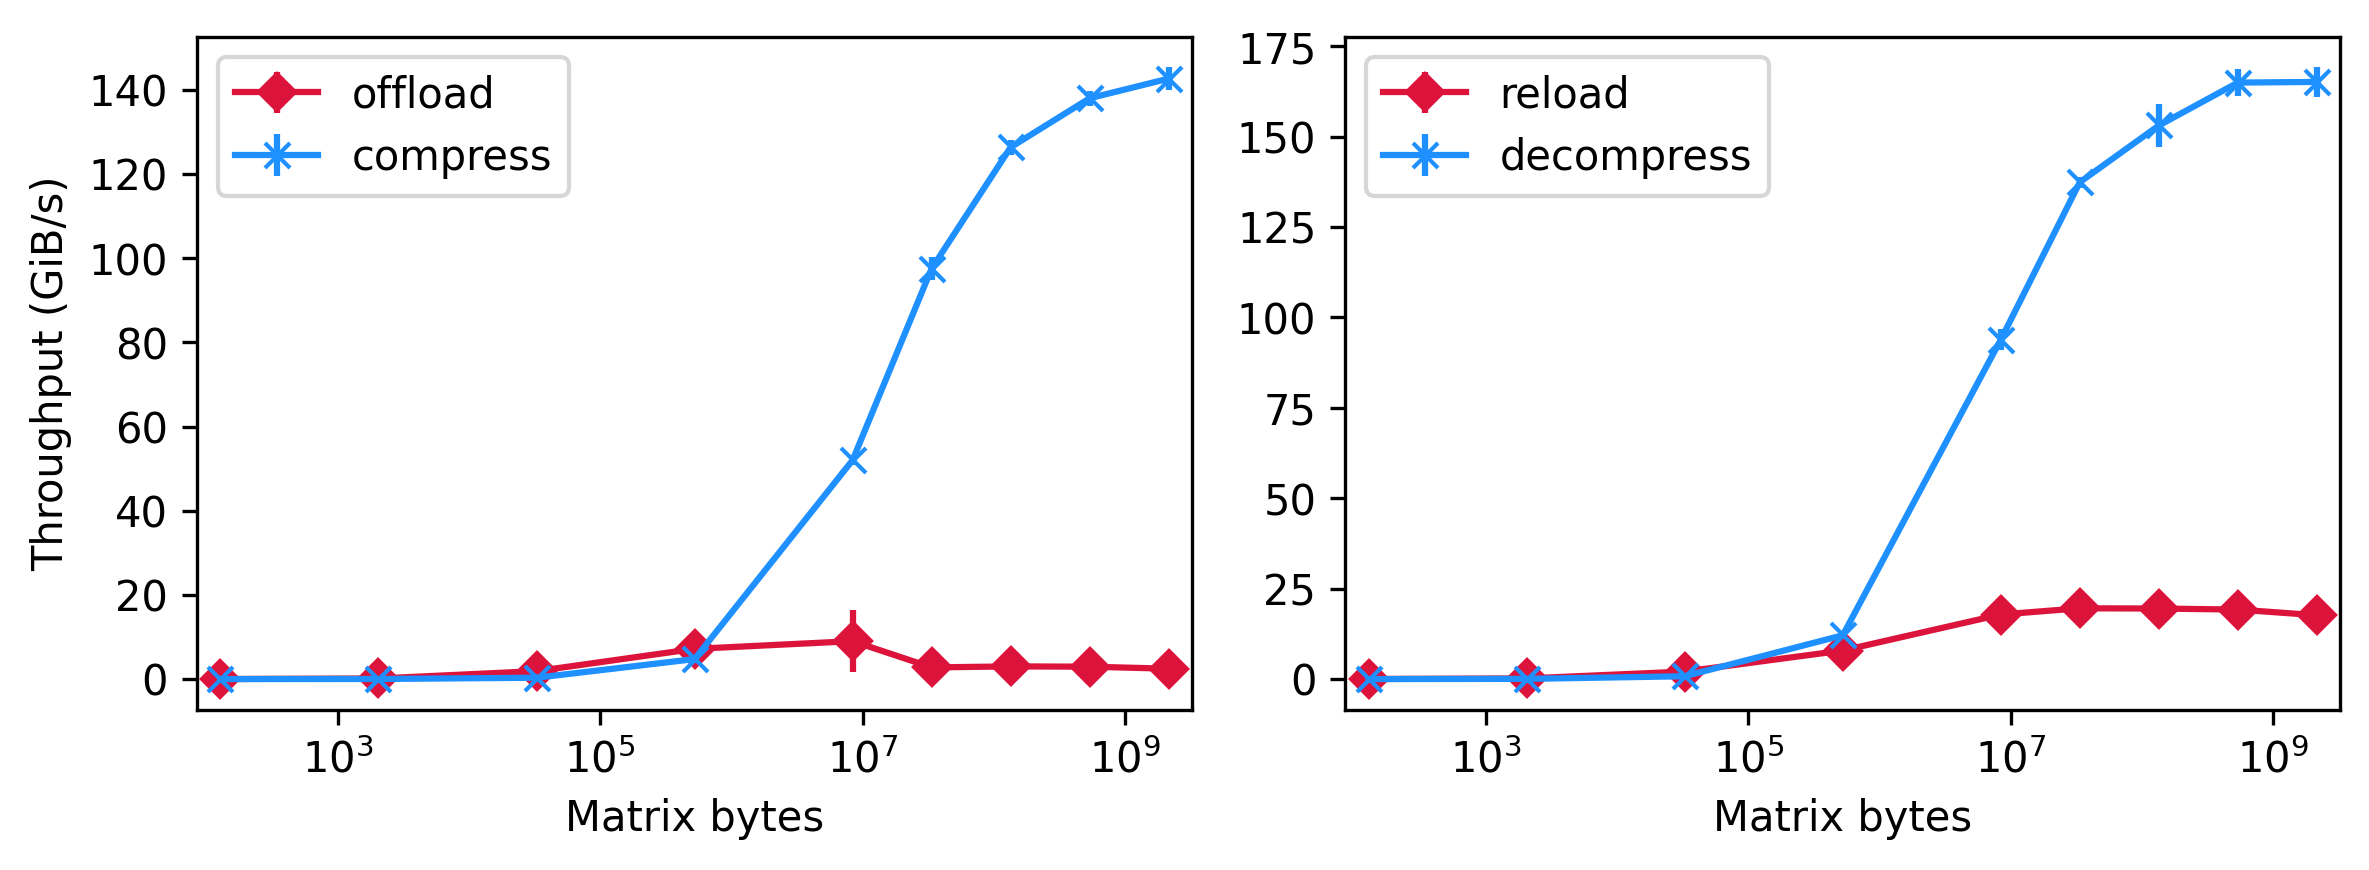

In [4]:
import time
import numpy as np

def benchmark(algo, matrix):
    if algo.__name__ == "decompress":
        handle = compress(matrix)
        args = (handle, )
    elif algo.__name__ == "reload":
        matrix = offload(matrix)
        args = (matrix, )
    else:
        args = (matrix, )

    throughputs = []
    for n in range(1, 10):
        start = time.perf_counter()
        algo(*args)
        throughput = matrix.nbytes / (time.perf_counter() - start) / 1024 / 1024 / 1024
        throughputs.append(throughput)

    throughputs = np.array(throughputs)
    mean = throughputs.mean()
    std = throughputs.std()
    return mean, std


def offload(matrix):
    cpu_matrix = matrix.cpu()
    return cpu_matrix

def reload(matrix):
    gpu_matrix = matrix.cuda()
    return gpu_matrix


def compress_decompress(matrix):
    handle = manager.write(matrix, "matrix")
    decompressed = manager.read(handle)
    return decompressed


def compress(matrix):
    handle = manager.write(matrix, "matrix")
    return handle

def decompress(handle):
    decompressed = manager.read(handle)
    return decompressed


def self_multiplication(matrix):
    return matrix @ matrix + matrix


algos = [offload, reload, compress, decompress]

import gc
import matplotlib.pyplot as plt



plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.autolayout'] = True
fig, ax = plt.subplots(1, 2, figsize=(8, 3))
colors = ['crimson', 'dodgerblue']
styles = ['D', 'x']

for algo, color, style in zip([offload, compress], colors, styles):
    xs = []
    ys = []
    es = []
    for matrix in matrices:
        mean, std = benchmark(algo, matrix)
        xs.append(matrix.nbytes)
        ys.append(mean)
        es.append(std)

    # plt.plot(xs, ys, label=algo.__name__.replace("_", "+"), color=color, marker=style)
    # ax[0].plot(xs, ys, label=algo.__name__.replace("_", "+"), color=color)
    ax[0].errorbar(xs, ys, yerr=es, color=color, marker=style, label=algo.__name__.replace("_", "+"))
    ax[0].set_xscale("log")
    ax[0].set_xlabel("Matrix bytes")
    ax[0].set_ylabel("Throughput (GiB/s)")
    ax[0].set_xlim(min(xs) / 1.5, max(xs) * 1.5)
    ax[0].legend()

for algo, color, style in zip([reload, decompress], colors, styles):
    xs = []
    ys = []
    es = []
    for matrix in matrices:
        mean, std = benchmark(algo, matrix)
        xs.append(matrix.nbytes)
        ys.append(mean)
        es.append(std)

    # ax[1].plot(xs, ys, label=algo.__name__.replace("_", "+"), color=color)
    ax[1].errorbar(xs, ys, yerr=es, color=color, marker=style, label=algo.__name__.replace("_", "+"))

    ax[1].set_xscale("log")
    ax[1].set_xlabel("Matrix bytes")
    ax[1].set_xlim(min(xs) / 1.5, max(xs) * 1.5)
    ax[1].legend()

plt.show()